# instagram image caption generator

# imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Add, Input
from tensorflow.keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, add
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import concurrent.futures
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import pickle

2025-05-05 07:00:49.987084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-05 07:00:49.987254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-05 07:00:50.158795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# dataset folder

In [2]:
# Define paths
data_folders = [
    # ('/kaggle/input/instagram-images-with-captions/instagram_data', '/kaggle/input/instagram-images-with-captions/instagram_data/captions_csv.csv'),
    ('/kaggle/input/instagram-images-with-captions/instagram_data2', '/kaggle/input/instagram-images-with-captions/instagram_data2/captions_csv2.csv')
]

In [3]:
# image_caption_img1 = pd.read_csv("/kaggle/input/instagram-images-with-captions/instagram_data/captions_csv.csv")
image_caption_img2 = pd.read_csv("/kaggle/input/instagram-images-with-captions/instagram_data2/captions_csv2.csv")

# sample of data

In [4]:
# image_caption_img1.sample(5).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

In [5]:
image_caption_img2 = image_caption_img2.set_axis(['Sr No','Image File','Caption'], axis=1)

In [6]:
image_caption_img2.sample(5).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,Sr No,Image File,Caption
7849,28366,img2/insta28366,Batman v/s Superman. They're Team Bat. #ohitswar #twoagainstoneisunfair #butnosurrender
5498,26015,img2/insta26015,dis kitty
9446,29963,img2/insta29963,About last night #friends #nightout #mumbai #worli #seaface #drive #actor #modelling #cross #pose
14035,34552,img2/insta34552,Never forget to love yourself ❤️
5140,25657,img2/insta25657,Toulouse spam


# captions loading

In [7]:
# Update the load_captions function to include file extensions in the paths
def load_captions(data_folders):
    captions_dict = {}
    for img_folder, caption_file in data_folders:
        df = pd.read_csv(caption_file)
        df.columns = df.columns.str.strip()  # Strip any leading/trailing spaces
        print(f"Columns in {caption_file}: {df.columns.tolist()}")  # Debugging line to check column names
        
        if 'Image File' in df.columns and 'Caption' in df.columns:
            for _, row in df.iterrows():
                img_path = os.path.join(img_folder, row['Image File'] + '.jpg')  # Add the file extension (e.g., '.jpg')
                if os.path.exists(img_path):
                    captions_dict[img_path] = row['Caption']
                else:
                    print(f"File not found: {img_path}")
        else:
            df.columns = ['Sr No', 'Image File', 'Caption']
            for _, row in df.iterrows():
                img_path = os.path.join(img_folder, row['Image File'] + '.jpg')  # Add the file extension (e.g., '.jpg')
                if os.path.exists(img_path):
                    captions_dict[img_path] = row['Caption']
                else:
                    pass
                    #print(f"File not found: {img_path}")
                
    return captions_dict

# Load captions with adjusted paths
captions_dict = load_captions(data_folders)

Columns in /kaggle/input/instagram-images-with-captions/instagram_data2/captions_csv2.csv: ['20516', 'img2/insta20516', 'wHaT dAy Is It Even #stayhomeclub']


In [8]:
print("Sample captions:", list(captions_dict.items())[:5])

Sample captions: [('/kaggle/input/instagram-images-with-captions/instagram_data2/img2/insta20517.jpg', 'Vitamin C for your fashion diet #KatyPursey #StayHome #ShoesdayTuesday @katyperrycollections'), ('/kaggle/input/instagram-images-with-captions/instagram_data2/img2/insta20518.jpg', 'do you know the hotter the fire the purer the gold is...'), ('/kaggle/input/instagram-images-with-captions/instagram_data2/img2/insta20519.jpg', '@ryanseacrest 👍🏻'), ('/kaggle/input/instagram-images-with-captions/instagram_data2/img2/insta20520.jpg', 'working hard or hardly working idk 🤷🏼\u200d♀️'), ('/kaggle/input/instagram-images-with-captions/instagram_data2/img2/insta20521.jpg', 'Step into your destiny with The Bondie 🔮✨ #ShoesdayTuesday @katyperrycollections')]


# preprocessing

In [9]:
# Preprocess images
def preprocess_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize to [0, 1]
    return img

# extracting features

In [10]:
# Extract features using InceptionV3
def extract_features(img_path, model):
    img = preprocess_image(img_path)
    features = model.predict(img)
    features = np.reshape(features, features.shape[1])
    return features

# sample of data

In [11]:
# Load InceptionV3 model
image_model = InceptionV3(weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-2].output
image_features_extract_model = Model(inputs=new_input, outputs=hidden_layer)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


# image processing

In [12]:
# # uncommented block
# import os
# import concurrent.futures
# from tqdm import tqdm

# # Define a function to extract features for a single image
# def process_image(img_path, pbar):
#     if os.path.exists(img_path):
#         features = extract_features(img_path, image_features_extract_model)
#         image_features[img_path] = features
#     else:
#         print(f"File not found: {img_path}")
#     pbar.update(1)  # Update the progress bar

# # Process images in parallel using threading
# image_features = {}
# with tqdm(total=len(captions_dict), desc="Processing images", leave=False) as pbar:
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         # Use threading instead of multiprocessing
#         futures = [executor.submit(process_image, img_path, pbar) for img_path in captions_dict.keys()]
#         for future in concurrent.futures.as_completed(futures):
#             pass  # Wait for all threads to complete

In [13]:
# # uncommented line
# # Save the extracted image features to a file
# output_file = "image_features_new.pkl"
# with open(output_file, "wb") as f:
#    pickle.dump(image_features, f)

In [12]:
# input_file = "/kaggle/working/image_features.pkl"
# input_file = "/kaggle/input/image_feature.pkl/other/default/1/image_features.pkl"
input_file = "/kaggle/input/image_features_new.pkl/tensorflow2/default/1/image_features_new.pkl"

with open(input_file, "rb") as f:
    image_features = pickle.load(f)

# for img_path, features in image_features.items():
#    print(f"Image Path: {img_path}")
#    print("Features:", features)

In [13]:
# Ensure captions_dict only contains paths that have corresponding image features
captions_dict = {k: v for k, v in captions_dict.items() if k in image_features}

In [14]:
# Filter out invalid captions
captions_dict = {k: v for k, v in captions_dict.items() if isinstance(v, str)}

# tokenization and padding

In [15]:
# Extract captions from the dictionary and handle missing values
captions = [caption if isinstance(caption, str) else '' for caption in captions_dict.values()]

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='<unk>')
tokenizer.fit_on_texts(captions)

# Convert captions to sequences
sequences = tokenizer.texts_to_sequences(captions)

# Pad the sequences
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

print("Tokenizer and sequences prepared successfully.")
print("Sample sequence:", sequences[2])
print("Padded sequence:", padded_sequences[2])
print("Max sequence length:", max_length)

Tokenizer and sequences prepared successfully.
Sample sequence: [1609, 3486]
Padded sequence: [1609 3486    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
Max sequence length: 26


# data generator

In [16]:
from keras.utils import to_categorical, Sequence

In [17]:
# Data generator
def data_generator(captions_dict, image_features, tokenizer, max_length, batch_size=32):
    keys = list(captions_dict.keys())
    
    def generator():
        for index in range(0, len(keys), batch_size):
            batch_keys = keys[index:index + batch_size]
            X1, X2, y = [], [], []
            for img_path in batch_keys:
                feature = image_features[img_path]
                caption = captions_dict[img_path]
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Ensure that X1 and X2 are tuples
                    X1.append(feature)
                    X2.append(in_seq)
                    # Append out_seq directly to y
                    y.append(out_seq)
            yield ((np.array(X1), np.array(X2)), np.array(y))

    return generator

In [18]:
# Get the vocabulary size from the tokenizer
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 for the <unk> token

In [19]:
print("Vocal_size is: ",vocab_size)

Vocal_size is:  19753


# model 1- encoder decoder

In [23]:
# # Model
# image_input = Input(shape=(2048,))
# image_dense1 = Dense(512, activation='relu')(image_input)
# image_dense2 = Dense(256, activation='relu')(image_dense1)  
# image_dense3 = Dense(256, activation='relu')(image_dense2)
# image_dense4 = Dense(256, activation='relu')(image_dense3)

# caption_input = Input(shape=(max_length,))
# embedding = Embedding(input_dim=vocab_size, output_dim=256)(caption_input)
# lstm = LSTM(256)(embedding)

# # Concatenate or add more dense layers for the image features and LSTM output
# merged = Add()([image_dense4, lstm])
# decoder_output = Dense(vocab_size, activation='softmax')(merged)

# model = Model(inputs=[image_input, caption_input], outputs=decoder_output)
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# print("Model created successfully.")

# model 2- bahdanau attention 

In [20]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Add
# from tensorflow.keras.models import Model
from keras.saving import register_keras_serializable

# === Parameters ===
embedding_dim = 2048
units = 256
vocab_size   # Update with your actual vocabulary size
max_length    # Update with your max caption length

# === Bahdanau Attention ===
@register_keras_serializable()
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):

        super(BahdanauAttention, self).__init__()

        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# === Encoder (Image Feature Extraction) ===
image_input = Input(shape=(2048,))
image_dense1 = Dense(512, activation='relu')(image_input)
image_dense2 = Dense(256, activation='relu')(image_dense1)  
image_dense3 = Dense(256, activation='relu')(image_dense2)
image_dense4 = Dense(256, activation='relu')(image_dense3)

# === Decoder (LSTM with Attention) ===
caption_input = Input(shape=(max_length,))
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(caption_input)
lstm = LSTM(units, return_state=True)
lstm_output, state_h, state_c = lstm(embedding)

# === Attention Mechanism ===
attention = BahdanauAttention(units)
context_vector, attention_weights = attention(image_dense4, state_h)

# === Concatenate Context Vector and LSTM Output ===
decoder_input = Add()([context_vector, lstm_output])

# === Final Output Layer ===
decoder_output = Dense(vocab_size, activation='softmax')(decoder_input)

# === Model Creation ===
model = Model(inputs=[image_input, caption_input], outputs=decoder_output)
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # or sparse_categorical_crossentropy based on your labels
    metrics=['accuracy']
)


print("Model created successfully.")


Model created successfully.


In [21]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 26, 2048)  │ 40,454,144 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     65,792 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │  2,360,320 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, 256),     │    131,841 │ dense_3[0][0],    │
│ (BahdanauAttention) │ (None, None, 1)]  │            │ lstm[0][1]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ bahdanau_attenti… │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 19753)     │  5,076,521 │ add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,334,826 (188.20 MB)

 Trainable params: 49,334,826 (188.20 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Create the dataset
train_dataset = tf.data.Dataset.from_generator(
    data_generator(captions_dict, image_features, tokenizer, max_length),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

In [24]:
validation_dataset = tf.data.Dataset.from_generator(
    data_generator(captions_dict, image_features, tokenizer, max_length),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

In [25]:
#from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, Callback

# Learning Rate Scheduler
#def lr_scheduler(epoch, lr):
#    if epoch < 5:
#        return lr
#    else:
#        return lr * tf.math.exp(-0.1)

# Custom Callback to Store Training Values
#class TrainingHistory(Callback):
#    def __init__(self):
#        self.history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': []}
    
#    def on_epoch_end(self, epoch, logs=None):
#        for key, value in logs.items():
#            if key in self.history:
#                self.history[key].append(value)

# Define callbacks
#lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
#early_stopping_callback = EarlyStopping(patience=3, restore_best_weights=True)
#training_history_callback = TrainingHistory()

In [26]:
# Verify data shapes
for features, captions in train_dataset.take(1):
    print("Features shape:", features[0].shape)
    print("Captions shape:", captions.shape)

Features shape: (275, 2048)
Captions shape: (275,)


# model-1 training

In [33]:
# train_dataset = train_dataset.repeat()

In [30]:
history = model.fit(train_dataset, 
                    # validation_split=0.2,
                    validation_data=validation_dataset,
                    epochs=100, 
                    verbose=1)
# history = model.fit(train_dataset, epochs=50, batch_size=16, verbose=1)  # Adjust batch size


Epoch 1/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.2137 - loss: 5.0966 - val_accuracy: 0.2216 - val_loss: 5.4396
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.2234 - loss: 4.8923 - val_accuracy: 0.2337 - val_loss: 5.2004
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.2391 - loss: 4.6468 - val_accuracy: 0.2439 - val_loss: 5.0032
Epoch 4/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.2527 - loss: 4.4938 - val_accuracy: 0.2499 - val_loss: 4.8998
Epoch 5/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.2766 - loss: 4.1714 - val_accuracy: 0.2872 - val_loss: 4.2311
Epoch 6/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.3014 - loss: 3.8679 - val_accuracy: 0.3054 - val_loss: 4.0364
Epoch 7/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.3298 - loss: 3.5821 - val_accuracy: 0.3225 - val_loss: 3.8527
Epoch 8/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.3629 - loss: 3

In [31]:
# # Save the model

model.save("/kaggle/working/bahdanau_model.keras")



# model evaluation

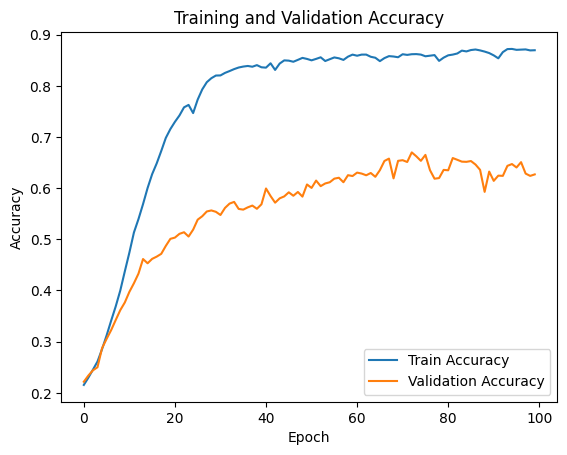

In [44]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [89]:
# import matplotlib.pyplot as plt
# from PIL import Image

# def display_image_with_caption(img_path, caption):
#     # Print to console
#     print("Predicted Caption:", caption)

#     # Show image with caption
#     img = Image.open(img_path)
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(caption, fontsize=12, color='green')
#     plt.show()

# # Example call (replace with your image path)
# display_image_with_caption(image_dir, "A dog playing in the park")


# bleu scores

In [33]:
image_dir = '/kaggle/input/instagram-images-with-captions/instagram_data/img'

# Retrieve image paths from the directory
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]

In [34]:
captions = [
    "nan",
    "bye",
    "Ok, a few more... sorry I just had so much fun that day",
    "This was one of my favorite shoots I’ve ever done! Thank you -a seriously badass woman, for shooting my cover! And thank you to everyone who asked a question for the interview 🤍",
    "Wrapped round my finger like a ring"
]

In [35]:
import random
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Define the number of samples you want to take
num_samples = 10

# Take a sample of 10 random elements from the dataset
sample_dataset = train_dataset.shuffle(buffer_size=1000).take(num_samples)

# Create lists to store predictions and actual captions
predictions = []
actual_captions = []

# Iterate over the sample_dataset and make predictions
for batch in sample_dataset:
    image_features, input_sequence = batch[0]
    prediction = model.predict([image_features, input_sequence])
    predictions.append(prediction)

    # Get the actual caption
    actual_caption_sequence = batch[1].numpy().squeeze().tolist()
    actual_caption = tokenizer.sequences_to_texts([actual_caption_sequence])[0]
    actual_captions.append(actual_caption)

# Calculate BLEU score for each prediction
bleu_scores = []
predicted_captions = []
smoothie = SmoothingFunction().method4

for prediction, actual_caption in zip(predictions, actual_captions):
    # Check the dimensions of the prediction and apply argmax accordingly
    if prediction.ndim == 3:
        predicted_indices = prediction.argmax(axis=2).squeeze().tolist()
    elif prediction.ndim == 2:
        predicted_indices = prediction.argmax(axis=1).tolist()
    else:
        raise ValueError("Unexpected prediction shape: {}".format(prediction.shape))
    
    # Convert predicted caption to text
    predicted_caption = tokenizer.sequences_to_texts([predicted_indices])[0]
    predicted_captions.append(predicted_caption)
    
    # Calculate BLEU score with smoothing
    bleu_score = sentence_bleu([actual_caption.split()], predicted_caption.split(), smoothing_function=smoothie)
    bleu_scores.append(bleu_score)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


# prediction dataset with bleu scores

In [45]:
results_df = pd.DataFrame({
    'Actual Caption': actual_captions,
    'Predicted Caption': predicted_captions,
    'BLEU Score': bleu_scores
})

results_df.style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,Actual Caption,Predicted Caption,BLEU Score
0,mi nueva en jenniferlopezcollection fashion 💘 ain't it something jlobts idol it's going down idol tbt from ddlovato and me love you kitten the jennifer lopez collection bracelets love in lala land and i love it everyday feelthelight who's on snapchat 😉 jlobts feelthelight an amazing day everyone believe in your light feelthelight dreamworkshome march27 here we call this sunday funday coconuts love for sleepy sleepy goodnight everybody to go watching americanidol tonight great performances the set feelthelight video home video coming soon home video coming soon feelthelight home monday morning help lol green and its two of my faves down this to an outtake from my people shoot love this pic mylife love coconuts march27 comingsoon badgalriri many great photos i can stop sharing benny this edit look zuhairmuradofficial this guy oscarweekend with the oscars and b vanityfair oscarweekend oscars beyonce by my favorite couple jennifer and oscars oscars lol oscars to steal this one from leahremini thanks my luv 😘 repost now mamas turn to party oscarweekend,you y ever 📷 nueva en ain't it ain't fall fashion looks look girl it's going down today look from that and bryce love you kitten the lopez collection collection love on the land and i made it you who being another 😉 need fun amazing day believe yourself feelthelight dreamworkshome march27 in with have me funday coconuts to a fun goodnight big raise watching the tonight on performances the road of home video shoot soon lebron of coming soon lebron video motivation may me link and its me me of my favorite the this and but to that outtake from my people i with this look mylife love coconuts march27 comingsoon badgalriri many baes photos i miss say do striveforgreatness striveforgreatness my photo to at my photo from last not allaboutyou the and oscars and valgabond my 💕 beyonce shoot gonna bb's couple jennifer and wow oscars loveaajkal musical musical saturday the get this a of yesterday justdoit for bff 😘 hrxbrand the there's my to e 🌬,0.183319
1,☁️ ☁️☁️☁️ down first leg of sweetener tour complete thank u so much ☺️ givenchyofficial 🖤 🖤 voguemagazine smile us leg almost over five more 🌬 years ☁️☁️☁️ years of break free u ✨ you’re welcome sm love presale tomorrow 10am local time 🖤 sale 6 26 🌫 birthday 💡 26 🌫 ♡ miss u nickiminaj best post i was going thru in i’m still going thru it enjoying singing r e m every night 🖤 this edit i am missing my 🖤 thank u for two beautiful nights he does is stare at me only human being alive who this filter pls me for a lil shows shows 🖤 one me and that’s how the grandes met the u soon givenchyofficial,☁️ ☁️ the time 🤪 my tour complete thank you 🖤 much ☁️ ☁️ kaaboo smile and leg almost over five more 🌬 years of years of you stella again welcome a love presale tomorrow 10am local time photo party 6 26 b ciarrap bad there my love i oh link you nickiminaj mom friends u was not thru in i’m still going thru in and the r the m every night 🖤 this edit i am sleeping missing my sweet kaaboo you for love beautiful loves she at me thing being alive find this filter pls me sweet my change photo look 🖤 and my back i real met the crew you soon,0.273790
2,new glasses thanks mr mrs are devotionnavy i feel devotionnavy your devotionnavy that's my nigga your moods devotionnavy a cute pu y navi of ask jah to show you what who they are much dick riding that my hurt your new fav tee yourself of was tokyo japan my bitch thick az phuck nightlife rock your work devotionnavy jealous fans u what friends are for this could be devotionnavy be lazy devotionnavy why was i never mind you grangrandolly that's please need this don't front http t co,own thanks mr mrs will my devotionnavy cute feel devotionnavy your devotionnavy that's my nigga your devotionnavy a pic pu y the of beauties he to show you what who they are much fun riding that my hurt my own photo before don't tokyo down my thick az phuck nightlife your work devotionnavy welcome 

# bleu score graph

In [46]:
from matplotlib import pyplot as plt
import seaborn as sns 

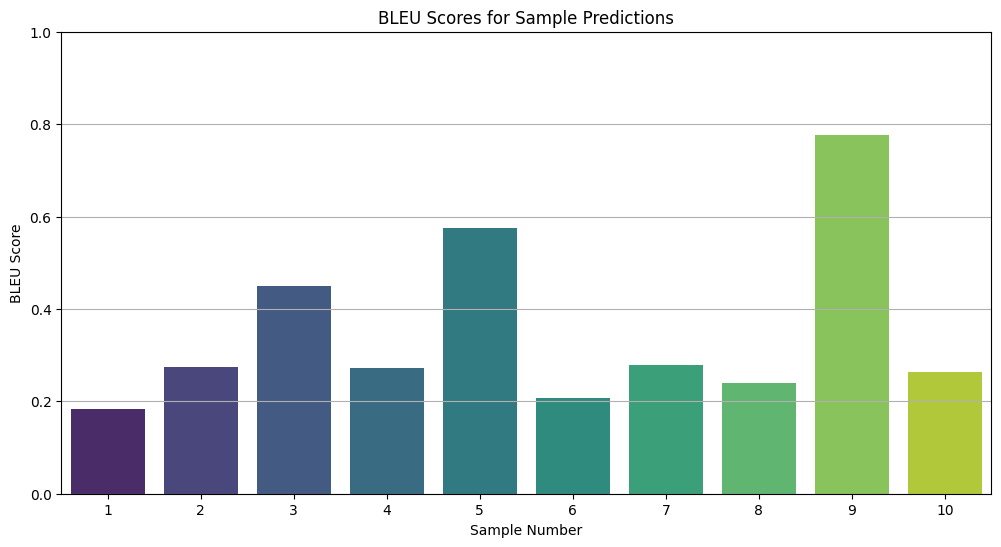

In [47]:
results_df['BLEU Score'] = results_df['BLEU Score'].astype(float)

# Plot the BLEU scores using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index + 1, y=results_df['BLEU Score'], palette="viridis")
plt.xlabel('Sample Number')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores for Sample Predictions')
plt.ylim(0, 1)  # BLEU score range is from 0 to 1
plt.grid(axis='y')

# Display the plot
plt.show()

In [48]:
average_bleu = np.mean(bleu_scores)
print(f"\nAverage BLEU Score on sample: {average_bleu:.4f}")


Average BLEU Score on sample: 0.3521


# model prediction

In [49]:
import random

# Define the number of samples you want to take
num_samples = 10

# Take a sample of 10 random elements from the dataset
sample_dataset = train_dataset.shuffle(buffer_size=num_samples).take(num_samples)

# Create a list to store predictions
predictions = []

# Iterate over the sample_dataset and make predictions
for batch in sample_dataset:
    image_features, input_sequence = batch[0]
    prediction = model.predict([image_features, input_sequence])
    predictions.append(prediction)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [50]:
predictions[0]

array([[4.8307087e-11, 6.5414999e-05, 9.3810755e-09, ..., 4.3544456e-11,
        4.7677952e-11, 4.6241216e-11],
       [2.2437827e-15, 1.0165616e-05, 9.9144204e-10, ..., 2.5222236e-15,
        2.8243471e-15, 2.0797484e-15],
       [4.5781972e-12, 6.5469772e-05, 6.6678105e-08, ..., 5.7155634e-12,
        6.1503528e-12, 5.7079593e-12],
       ...,
       [3.7685889e-11, 7.6865238e-01, 6.1503910e-05, ..., 4.2463214e-11,
        3.5444443e-11, 3.7621756e-11],
       [1.0750498e-12, 7.3048689e-08, 2.2130740e-08, ..., 1.0903956e-12,
        1.2827725e-12, 9.9234325e-13],
       [1.4835242e-12, 3.7260961e-08, 2.5687868e-08, ..., 2.1498946e-12,
        2.1153287e-12, 1.4245132e-12]], dtype=float32)

In [51]:
# Convert predictions to captions
captions = []
for prediction in predictions:
    caption = []
    for word_index in np.argmax(prediction, axis=1):
        word = tokenizer.index_word[word_index]
        caption.append(word)
    captions.append(caption)

In [52]:
print("[", end="")
for word in captions[0]:
    print(f"'{word}'", end=", ")
print("]")

['eve', '➡', 'christmas', 'day', '<unk>', 'cozylittlechristmas', 'link', 'in', 'bio', '📸', 'nadialeelee', '<unk>', 'me', 'like', '<unk>', 'cozylittlechristmas', 'link', 'in', 'bio', '📸', 'nadialeelee', '<unk>', 'get', 'through', 'this', '<unk>', 'it', 'for', 'the', '<unk>', 'amongst', 'other', 'things', '<unk>', '📸', 'manthony783', 'vogue', 'american', 'idol', 'on', 'it', 'again', 'americanidol', 'looking', 'for', 'her', '<unk>', '<unk>', 'early', '<unk>', 'vijatm', '💘', 'pink', 'it', 'was', 'love', 'at', 'first', 'sight', '🎀', '<unk>', 'and', 'authentic', '<unk>', 'friends', 'ladygaga', '<unk>', 'kpwww', 'evil', 'about', 'this', '👁', 'head', 'to', 'katyperrycollections', 'for', 'the', '<unk>', '💙', 'kaaboo', '💗', '📸', 'shearerphoto', 'kaaboo', '💚', '📸', 'shearerphoto', 'kaaboo', '🖤', '📸', 'shearerphoto', 'holiday', '♥️', '📸', 'shearerphoto', 'to', '💚', 'meet', 'me', 'at', 'sunset', '<unk>', '7', '30pm', '📸', 'manthony783', '<unk>', '<unk>', 'you', 'soon', 'san', 'diego', 'link', 'in',

# translation

In [54]:
pip install googletrans==4.0.0-rc1


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=467ddeb3180c0da530662e54106a352292e725d874622768add5f4d2ef16e02c
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Succ

In [58]:
from googletrans import Translator

def translate_caption(caption, dest_language='hi'):  # 'hi' for Hindi, 'fr' for French, etc.
    translator = Translator()
    translated = translator.translate(caption, dest=dest_language)
    return translated.text


In [86]:
caption = ["last night by styledbyhrush and justinemarjan mom northie this face 😍😍 right on that mom for life 😍😍 head tilt to like i'm is a candid photo 🤣 cute are my i goodsquad rose striveforgreatness com is me smile 💜 was on that real shit amazing good waist side has just dropped on goodamerican com goodsquad love i just stand how cute they are auntie koko loves you lebron 5 31 17 gfirestone13 the awesome time ad trip with the up tonight e you spot or the real deal for nbc 🖤 b day to the queen the nikecourt the legend that is kris jenner is coming but i love her crazy little self good pass girl i for revenge body 💪🏽 got most precious girl dreamy dream 😍😍😍😍 auntie koko loves you should film us watching tv but tonight we made an victory so please thank sashasamsonova standard magazine please thank you eveningstandardmagazine for my feature ❤️ vibes we dropping soon about to be crazy tape dropping in 2018 and 💕 morning down be a good day in my goodamerican good legs 💙💙 mom mommy i love you ❤️ vibes	"
          ]
translated_captions = [translate_caption(caption, dest_language='hi') for caption in captions]

# Print original and translated captions

print("Original:", caption)
print(" ")
print("Translated:", translated_caption)


Original: ["last night by styledbyhrush and justinemarjan mom northie this face 😍😍 right on that mom for life 😍😍 head tilt to like i'm is a candid photo 🤣 cute are my i goodsquad rose striveforgreatness com is me smile 💜 was on that real shit amazing good waist side has just dropped on goodamerican com goodsquad love i just stand how cute they are auntie koko loves you lebron 5 31 17 gfirestone13 the awesome time ad trip with the up tonight e you spot or the real deal for nbc 🖤 b day to the queen the nikecourt the legend that is kris jenner is coming but i love her crazy little self good pass girl i for revenge body 💪🏽 got most precious girl dreamy dream 😍😍😍😍 auntie koko loves you should film us watching tv but tonight we made an victory so please thank sashasamsonova standard magazine please thank you eveningstandardmagazine for my feature ❤️ vibes we dropping soon about to be crazy tape dropping in 2018 and 💕 morning down be a good day in my goodamerican good legs 💙💙 mom mommy i love